# INM707: Advanced Tasks ($n$-step Deep Q-Network)

We use PyTorch to construct an [$n$-Step Return DQN](https://link.springer.com/article/10.1007/BF00115009) Deep Q-Network, Gymnasium to make the environment suitable for training, and [ViZDoom](https://vizdoom.farama.org/) which contains our 'Defend The Center' environment. MoviePy is optionally used to record the agent on an example episode after training, and sadly due to a problem within the MoviePy package itself, MoviePy needs to be installed before running the notebook (or the notebook kernel needs to be restarted after installing MoviePy - which is not possible when running a notebook in the background on Kaggle).

Since we are making sequential improvements to the previous architecture, in this notebook we are working with a Target Network + Prioritised Experience Replay + Noisy Network + $n$-Step Return Deep Q-Network.

The work presented here is part of the coursework of the INM707 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM707).

### Import Libraries

We use PyTorch for creating our Deep Q-Network. Gymnasium and ViZDoom are used for the environment. Matplotlib is used for generating any plots.

In [1]:
# Import Relevant Libraries
import operator
from collections import deque
from IPython.display import clear_output

import os
import pickle
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

In [2]:
!pip install gymnasium vizdoom moviepy

import gymnasium as gym
from gymnasium.wrappers import FrameStack, TransformReward, RecordVideo
from vizdoom import gymnasium_wrapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 82.9 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=c7e1d85899379e0ba8a634f192fcb9197e0fa4c4beff58564b6630f0e523a188
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


### Set Random Seed and Default Device

In order to reproduce the results every time we run the notebook, we set a random seed. We also try to use a GPU if available.

In [3]:
# Set random seed for reproducibility
randomer = 50
random.seed(randomer)
np.random.seed(randomer)
torch.manual_seed(randomer)
torch.cuda.manual_seed_all(randomer)

# Default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


### Segment Trees

A segment tree is used to store information about segments, and can be used to efficiently store and sample transitions for prioritised experience replay.

The code is inspired by that found in the [Rainbow is all you need!](https://github.com/Curt-Park/rainbow-is-all-you-need) repository, with some changes.

In [4]:
## As found in https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/08.rainbow.ipynb ##
## With some changes ##

class SegmentTree:
    """ Create SegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    Attributes:
        capacity (int)
        tree (list)
        operation (function)
    """
    def __init__(self, capacity, operation, init_value):
        """Initialisation.
        Args:
            capacity (int)
            operation (function)
            init_value (float)
        """
        assert (capacity > 0 and capacity & (capacity - 1) == 0), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(self, start, end, node, node_start, node_end):
        """
        Returns result of operation in segment.
        """
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(self._operate_helper(start, mid, 2 * node, node_start, mid), self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end))

    def operate(self, start = 0, end = 0):
        """
        Returns result of applying 'self.operation'.
        """
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx, val):
        """
        Set value in tree.
        """
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx):
        """
        Get real value in leaf node of tree.
        """
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]

class SumSegmentTree(SegmentTree):
    """ Create SumSegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    """
    def __init__(self, capacity):
        """Initialisation.
        Args:
            capacity (int)
        """
        super(SumSegmentTree, self).__init__(capacity = capacity, operation = operator.add, init_value = 0.0)

    def sum(self, start = 0, end = 0):
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound):
        """
        Find the highest index 'i' about upper bound in the tree.
        """
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity

class MinSegmentTree(SegmentTree):
    """ Create SegmentTree.
    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py
    """
    def __init__(self, capacity):
        """Initialisation.
        Args:
            capacity (int)
        """
        super(MinSegmentTree, self).__init__(capacity = capacity, operation = min, init_value = float("inf"))

    def min(self, start = 0, end = 0):
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

### Replay Buffer

A replay buffer stores and replays experiences gathered from interactions of our agent with the environment. It is a fundamental component of a Deep Q-Network, tackling the problem of autocorrelation which can lead to unstable training.

The code is inspired by that found in the [Rainbow is all you need!](https://github.com/Curt-Park/rainbow-is-all-you-need) repository, with some changes.

In [5]:
class ReplayBuffer:
    """
    A simple NumPy replay buffer.
    """
    def __init__(self, obs_shape, size, batch_size = 32, n_step = 3, gamma = 0.99):
        self.obs_buf = np.zeros([size] + list(obs_shape), dtype = np.float32)
        self.next_obs_buf = np.zeros([size] + list(obs_shape), dtype = np.float32)
        self.acts_buf = np.zeros([size], dtype = np.float32)
        self.rews_buf = np.zeros([size], dtype = np.float32)
        self.done_buf = np.zeros(size, dtype = np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # For N-step Learning
        self.n_step_buffer = deque(maxlen = n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(self, obs, act, rew, next_obs, done):
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # Single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()

        # Make an n-step transition
        rew, next_obs, done = self._get_n_step_info(self.n_step_buffer, self.gamma)
        obs, act = self.n_step_buffer[0][:2]

        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self):
        idxs = np.random.choice(self.size, size = self.batch_size, replace = False)

        return dict(obs = self.obs_buf[idxs], next_obs = self.next_obs_buf[idxs], acts = self.acts_buf[idxs], rews = self.rews_buf[idxs], done = self.done_buf[idxs], indices = idxs)

    def sample_batch_from_idxs(self, idxs):
        # for N-step Learning
        return dict(obs = self.obs_buf[idxs], next_obs = self.next_obs_buf[idxs], acts = self.acts_buf[idxs], rews=self.rews_buf[idxs], done = self.done_buf[idxs])

    def _get_n_step_info(self, n_step_buffer, gamma):
        """
        Return n step rew, next_obs, and done.
        """
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self):
        return self.size

### Prioritised Experience Replay Buffer

Prioritised experience replay ensures that important transitions are replayed more frequently, which allows for improved learning. Transitions are prioritised by the size of the temporal difference error.

The code is inspired by that found in the [Rainbow is all you need!](https://github.com/Curt-Park/rainbow-is-all-you-need) repository, with some changes.

In [6]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """
    Prioritized Replay Buffer
    """
    def __init__(self, obs_shape, size, batch_size = 32, alpha = 0.5, n_step = 3, gamma = 0.99):
        """
        Initialisation
        """
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(obs_shape, size, batch_size, n_step, gamma)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(self, obs, act, rew, next_obs, done):
        """
        Store experience and priority.
        """
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta = 0.4):
        """
        Sample a batch of experiences.
        """
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(obs = obs, next_obs = next_obs, acts = acts, rews = rews, done = done, weights = weights, indices = indices)

    def update_priorities(self, indices, priorities):
        """
        Update priorities of sampled transitions.
        """
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self):
        """
        Sample indices based on proportions.
        """
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx, beta):
        """
        Calculate the weight of the experience at idx.
        """
        # Get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        # Calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

### Noisy Linear

A noisy linear layer is a standard linear layer that contains parametric noise in its weights. This adds stochasticity to the agent's policy, leading to efficient exploration. This replaces the $\epsilon$-greedy policy commonly used in reinforcement learning problems.

The code is inspired by that found in the [RL-Adventure](https://github.com/higgsfield/RL-Adventure/) repository, with some changes.

In [7]:
## As found in https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb ##
## With some changes ##

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init = 0.5):
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features, device = device, dtype = torch.float, requires_grad = True))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features, device = device, dtype = torch.float, requires_grad = True))
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features, device = device, dtype = torch.float))

        self.bias_mu = nn.Parameter(torch.empty(out_features, device = device, dtype = torch.float, requires_grad = True))
        self.bias_sigma = nn.Parameter(torch.empty(out_features, device = device, dtype = torch.float, requires_grad = True))
        self.register_buffer("bias_epsilon", torch.empty(out_features, device = device, dtype = torch.float))

        self.reset_parameters()
        self.reset_noise()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu

        return F.linear(x, weight, bias)

    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.in_features)

        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        
        if self.bias_mu is not None:
            self.bias_mu.data.uniform_(-mu_range, mu_range)
            self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        
        if self.bias_mu is not None:
            self.bias_epsilon.copy_(epsilon_out)

    def scale_noise(self, size):
        if isinstance(size, int):
            size = (size,)
        x = torch.randn(size, device = self.weight_mu.device)
        return x.sign().mul_(x.abs().sqrt_())

### $n$-Step Deep Q-Network

The model is a convolutional neural network, allowing for pixel data to be input. Three convolutional layers and two noisy linear layers are used as found in the code. The model also outputs an action based on an input state, using an exploratory policy formed by the noisy networks. Note that this is the same model as found in the Noisy Network Deep Q-Network notebook, since we are only adding $n$-step returns here and not any neural network modifications.

The code is inspired by that found in the [RL-Adventure](https://github.com/higgsfield/RL-Adventure/) repository, with some changes.

In [8]:
## As found in https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb ##
## With some changes ##

class NoisyDQN(nn.Module):
    def __init__(self, input_shape, num_actions, noisy_std = 0.5):
        super(NoisyDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1),
            nn.ReLU()
        ).to(device)
        
        self.noisy1 = NoisyLinear(self.feature_size(), 512, std_init = noisy_std)
        self.noisy2 = NoisyLinear(512, num_actions, std_init = noisy_std)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = x / 255.0
        x = self.features(x)
        x = x.view(batch_size, -1)
        
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        return x
    
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape, device = device)).view(1, -1).size(1)
    
    def act(self, state):
        if torch.is_tensor(state) == False:
            state = np.array(np.float32(state))
            state = torch.tensor(np.float32(state), dtype = torch.float, device = device).unsqueeze(0)
        q_value = self.forward(state)
        action = int(q_value.max(1)[1].data[0])
        return action

### Environment Selection

We define the actual environment to use, which in our case is the ViZDoom 'Defend The Center' environment. Frame skipping is also employed.

In [9]:
env_id = "VizdoomDefendCenter-v0"
env = gym.make(env_id, render_mode = "rgb_array", frame_skip = 4)

print(f"Observation Space: {env.observation_space}\nAction Space: {env.action_space}")

env.action_space.seed(randomer)

/opt/conda/lib/python3.10/site-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


Observation Space: Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (2,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8))
Action Space: Discrete(4)


[50]

### Environment Manipulation

We need to preprocess our environment accordingly in order for it to pass through the Deep Q-Network. The observations from ViZDoom are provided as dictionaries, which Gymnasium does not accept, meaning that we need to translate these dictionaries into actual objects acceptable by Gymnasium. The dictionary consists of two items, namely 'gamevariables' and 'screen'. We need the 'screen' item, which contains the actual pixel space that a human would view if they were to play the ViZDoom game themselves. Grayscaling is employed on the frames, since colours do not provide important information. The reward can optionally be scaled by some parameter if desired, though this is commented out and not performed in our work. Framestacking is employed as the final step.

In [10]:
class ObservationWrapper(gym.ObservationWrapper):
    """
    ViZDoom environments return dictionaries as observations, containing
    the main image as well other info.
    The image is also too large for normal training.

    This wrapper replaces the dictionary observation space with a simple
    Box space (i.e., only the RGB image), and also resizes the image to a
    smaller size.

    NOTE: Ideally, you should set the image size to smaller in the scenario files
          for faster running of ViZDoom. This can really impact performance,
          and this code is pretty slow because of this!
    """
    def __init__(self, env, shape = (84, 84)):
        super().__init__(env)
        self.image_shape = shape
        self.image_shape_reverse = shape[::-1]

        # Create new observation space with the new shape
        print(env.observation_space)
        num_channels = env.observation_space["screen"].shape[-1]
        new_shape = (shape[0], shape[1], num_channels)
        self.observation_space = gym.spaces.Box(
            0, 255, shape = new_shape, dtype = np.uint8
        )

    def observation(self, observation):
        observation = cv2.resize(observation["screen"], self.image_shape_reverse)
        return observation

class GrayScaleObservation(gym.ObservationWrapper):
    """
    Convert the image observation from RGB to grayscale.
    Example:
        >>> env = gym.make('CarRacing-v1')
        >>> env.observation_space
        Box(0, 255, (96, 96, 3), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'))
        >>> env.observation_space
        Box(0, 255, (96, 96), uint8)
        >>> env = GrayScaleObservation(gym.make('CarRacing-v1'), keep_dim=True)
        >>> env.observation_space
        Box(0, 255, (96, 96, 1), uint8)
    """
    def __init__(self, env: gym.Env, keep_dim: bool = False):
        """
        Convert the image observation from RGB to grayscale.
        Args:
            env (Env): The environment to apply the wrapper
            keep_dim (bool): If `True`, a singleton dimension will be added, i.e. observations are of the shape AxBx1.
                Otherwise, they are of shape AxB.
        """
        super().__init__(env)
        self.keep_dim = keep_dim

        assert (
            isinstance(self.observation_space, gym.spaces.Box)
            and len(self.observation_space.shape) == 3
            and self.observation_space.shape[-1] == 3
        )

        obs_shape = self.observation_space.shape[:2]
        if self.keep_dim:
            self.observation_space = gym.spaces.Box(
                low = 0, high = 255, shape = (obs_shape[0], obs_shape[1], 1), dtype = np.uint8
            )
        else:
            self.observation_space = gym.spaces.Box(
                low = 0, high = 255, shape = obs_shape, dtype = np.uint8
            )

    def observation(self, observation):
        """
        Converts the colour observation to grayscale.
        Args:
            observation: Color observations
        Returns:
            Grayscale observations
        """

        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        if self.keep_dim:
            observation = np.expand_dims(observation, -1)
        return observation

# Apply Wrappers to environment (working for ViZDoom environments only, replace with standard Gymnasium ones for other environments)
env = ObservationWrapper(env)
env = GrayScaleObservation(env)
# Transforms reward by scalar, can be commented out if not needed
#env = TransformReward(env, lambda r: r * 0.01)

# Frame stacking
if gym.__version__ < "0.26":
    env = FrameStack(env, num_stack = 4, new_step_api = True)
else:
    env = FrameStack(env, num_stack = 4)

print(f"Observation Space: {env.observation_space}\nAction Space: {env.action_space}")

Dict('gamevariables': Box(-3.4028235e+38, 3.4028235e+38, (2,), float32), 'screen': Box(0, 255, (240, 320, 3), uint8))
Observation Space: Box(0, 255, (4, 84, 84), uint8)
Action Space: Discrete(4)


### Adjust Learning Rate and Moving Average Plotting

While not an important step, we can scale the learning rate during training as a method to improve the gradient descent algorithm, by making smaller steps to the global minimum. The moving average is a sensible way to visualise the performance of our agent during training, which essentially calculates the moving average reward between a window of a certain number of episodes.

In [11]:
# Scale learning rate
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor

    optimizer: optimizer whose learning rate must be shrunk
    shrink_factor: factor in interval (0, 1) to multiply learning rate with
    """

    print("\nDECAYING learning rate")
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]["lr"]))

# Calculate moving average (for plotting)
def moving_average(data, window_size = 100):
    return np.convolve(a = data, v = np.ones(window_size), mode = "valid") / window_size

### Model and Training Hyperparameters

The model and training hyperparameters are defined here, including the number of frames to train for, the replay buffer size, any policy related parameters, and the choice of optimiser.

In [12]:
num_frames = 1000000
memory_size = 100000
batch_size = 32
target_update = 8000
seed = 50

## Discount Factor ##
gamma = 0.99

## Prioritised Experience Replay ##
alpha = 0.5
beta = 0.4
prior_eps = 0.000001

## Noisy Network ##
noisy_std = 0.5

## N-step Returns ##
n_step = 3

## Optimizer ##
learning_rate = 0.00001
optimizer = "adam"

### $n$-Step DQN Agent Class

We create a class for our agent, which will train the agent using the defined hyperparameters. The class comes with .train() and .test() functions, which train the agent for a set number of frames and test the agent on a single episode respectively.

The code is inspired by that found in the [Rainbow is all you need!](https://github.com/Curt-Park/rainbow-is-all-you-need) repository, with some changes.

In [13]:
## As found in https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/07.n_step_learning.ipynb ##
## With some changes ##

class NStepAgent:
    """
    N-step (with PER, Noisy Networks) DQN Agent
    """

    def __init__(self, env, memory_size, batch_size, target_update, seed, gamma = 0.99, alpha = 0.5, beta = 0.4, prior_eps = 0.000001, noisy_std = 0.5, n_step = 3, learning_rate = 0.0000625, optimizer = "adam"):
        """
        Initialise the N-step DQN agent with the provided parameters.
        
        Args:
            env (gymnasium.Env): Gymnasium environment
            memory_size (int): Size of the replay memory
            batch_size (int): Size of minibatches sampled from the replay memory
            target_update (int): Frequency (in steps) at which to update the target network
            seed (int): Seed for random number generation
            gamma (float): Discount factor (default: 0.99)
            alpha (float): Alpha parameter for prioritized experience replay (default: 0.5)
            beta (float): Beta parameter for prioritized experience replay (default: 0.4)
            prior_eps (float): Small positive constant to ensure non-zero priorities (default: 0.000001)
            noisy_std (float): Standard deviation for noisy networks (default: 0.5)
            n_step (int): Number of steps for n-step DQN (default: 3)
            learning_rate (float): Learning rate for the optimizer (default: 0.0000625)
            optimizer (str): Name of the optimizer to use ("adam", "rmsprop", or "sgd") (default: "adam")
        """
        obs_dim = env.observation_space.shape
        action_dim = env.action_space.n

        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.prior_eps = prior_eps
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        
        self.n_step = n_step
        self.memory = PrioritizedReplayBuffer(obs_dim, memory_size, batch_size, alpha, n_step, gamma)

        # Action space seed
        self.env.action_space.seed(seed)

        # Neural network models setup
        self.dqn = NoisyDQN(obs_dim, action_dim, noisy_std = noisy_std).to(self.device)
        self.dqn_target = NoisyDQN(obs_dim, action_dim, noisy_std = noisy_std).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # Optimizer setup
        optimizer.lower()
        if optimizer == "adam":
            self.optimizer = optim.Adam(self.dqn.parameters(), lr = learning_rate)
        if optimizer == "rmsprop":
            self.optimizer = optim.RMSprop(self.dqn.parameters(), lr = learning_rate)
        if optimizer == "sgd":
            self.optimizer = optim.SGD(self.dqn.parameters(), lr = learning_rate)

        # Transition to store in memory
        self.transition = list()
        
        # Mode: train / test
        self.is_test = False

    def select_action(self, state):
        """
        Select an action from the input state.
        """
        selected_action = self.dqn.act(state)
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action):
        """
        Take an action and return the response of the environment.
        """
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self):
        """
        Update the model by gradient descent.
        """
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.tensor(samples["weights"].reshape(-1, 1), dtype = torch.float, device = self.device).to(self.device)
        indices = samples["indices"]

        # N-step Learning loss
        samples = self.memory.sample_batch_from_idxs(indices)
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma ** self.n_step)
            
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames, plotting_interval = 1000):
        """
        Train the agent.
        """
        self.is_test = False
        
        state, _ = self.env.reset(seed = self.seed)
        update_cnt = 0
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            # At the halfway point, reduce learning rate by a tenth
            if frame_idx == int(num_frames // 2):
                adjust_learning_rate(self.optimizer, 0.1)

            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # If episode ends
            if done:
                state, _ = self.env.reset(seed = self.seed)
                scores.append(score)
                score = 0

            # If training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # If hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # Plot and save results, and save models
            if frame_idx % plotting_interval == 0:
                self._plot(scores, losses)
                self._save(scores, losses)

                print(f"Frame: {frame_idx}, Mean of last 10 rewards: {np.mean(scores[-10:])}")

                # Create checkpoint folder
                if not os.path.exists("checkpoints"):
                    os.makedirs("checkpoints")

                # Save the model checkpoint
                checkpoint_name = f"checkpoint_nstep_dqn_latest.pth.tar"
                checkpoint_path = os.path.join("checkpoints", checkpoint_name)
                torch.save({"current_model": self.dqn.state_dict(), "target_model": self.dqn_target.state_dict(), "optimizer": self.optimizer.state_dict(), "losses": losses, "rewards": scores, "frame": frame_idx}, checkpoint_path)

        print("Training successfully completed.")

        self.env.close()

    def test(self, video_folder = "nstep-dqn_agent_video"):
        """
        Test the agent.
        """
        self.is_test = True
        
        # Create checkpoint folder
        if not os.path.exists(video_folder):
            os.makedirs(video_folder)
        
        # For recording a video of agent
        naive_env = self.env
        self.env = RecordVideo(self.env, video_folder = video_folder)
        
        state, _ = self.env.reset(seed = self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("Score: ", score)
        self.env.close()
        
        # Reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples, gamma):
        """
        Return DQN loss.
        """
        state = torch.tensor(samples["obs"], dtype = torch.float, device = self.device).to(self.device)
        next_state = torch.tensor(samples["next_obs"], dtype = torch.float, device = self.device).to(self.device)
        action = torch.tensor(samples["acts"].reshape(-1, 1), dtype = torch.long, device = self.device).to(self.device)
        reward = torch.tensor(samples["rews"].reshape(-1, 1), dtype = torch.float, device = self.device).to(self.device)
        done = torch.tensor(samples["done"].reshape(-1, 1), dtype = torch.float, device = self.device).to(self.device)

        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim = 1, keepdim = True)[0].detach()
        mask = 1 - done
        target = (reward + gamma * next_q_value * mask).to(self.device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target, reduction = "none")

        return loss

    def _target_hard_update(self):
        """
        Hard update: target <- local.
        """
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _save(self, rewards, losses):
        """
        Save training results to a pickle file.
        """
        # Save results to a file
        with open("nstep-dqn-results.pkl", "wb") as f:
            pickle.dump(rewards, f)
            pickle.dump(losses, f)

    def _plot(self, rewards, losses, moving_average_window = 100):
        """
        Plot training curves.
        """
        plt.figure(figsize = (40, 6))
        clear_output(True)
        # Combined plot of rewards, moving average, and loss
        plt.subplot(131)
        plt.title("NStep-DQN Rewards Per Episode")
        plt.plot(rewards, label = "Reward")
        if len(rewards) >= moving_average_window:
            plt.plot(moving_average(rewards, moving_average_window), label = "Moving Average", color = "red")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        
        plt.subplot(132)
        plt.title("NStep-DQN Loss Per Frame")
        plt.plot(losses, label = "DQN Loss")
        plt.xlabel("Frame")
        plt.ylabel("Loss")
        
        plt.savefig("nstep_dqn_plot.pdf")
        plt.show()

    def _load_checkpoint(self, checkpoint_path, include_optimiser = True):
        """
        Load the models from a checkpoint.
        """
        model = torch.load(checkpoint_path, map_location = self.device)
        self.dqn.load_state_dict(model["current_model"])
        self.dqn_target.load_state_dict(model["target_model"])
        
        if include_optimiser == True:
            self.optimizer.load_state_dict(model["optimizer"])

### Creating $n$-Step-DQN Agent Object

We create an object for the agent to later refer to. This allows us to train and test the agent as desired.

In [14]:
agent = NStepAgent(env, memory_size, batch_size, target_update, seed, gamma, alpha, beta, prior_eps, noisy_std, n_step, learning_rate, optimizer)

cuda


### Train Agent

We train the agent using our previously defined hyperparameters and obtain live plots of the training performance, which display the reward per episode, and the loss per frame.

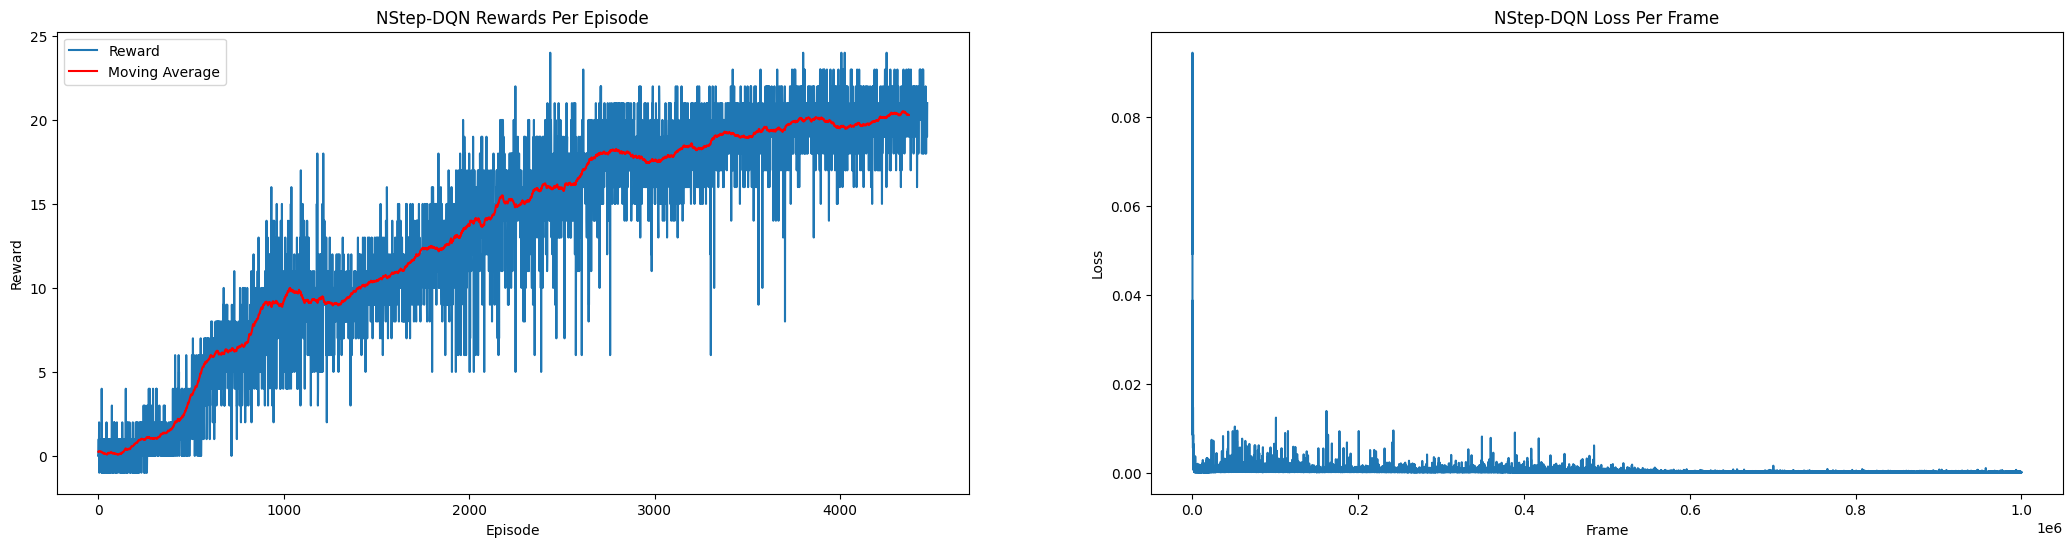

Frame: 1000000, Mean of last 10 rewards: 20.4
Training successfully completed.
CPU times: user 4h 24min 1s, sys: 4min 21s, total: 4h 28min 22s
Wall time: 4h 49min 43s


In [15]:
%%time

#agent._load_checkpoint("checkpoints/checkpoint_nstep_dqn_latest.pth.tar", include_optimiser = True)
agent.train(num_frames)

### Test Agent

We test the agent and receive a video of the agent playing on the ViZDoom environment. As mentioned at the beginning of the notebook, MoviePy causes an error as it needs to be installed before running the notebook (or the notebook kernel needs to be restarted after installing MoviePy. We obtain this error here as Kaggle cannot handle this, though it should be easy to avoid this on a home computer.

In [16]:
%%time

agent.test(video_folder = "nstep_agent_video")

/opt/conda/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /kaggle/working/nstep_agent_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /kaggle/working/nstep_agent_video/rl-video-episode-0.mp4.
Moviepy - Writing video /kaggle/working/nstep_agent_video/rl-video-episode-0.mp4



TypeError: must be real number, not NoneType